# **Group Work Project 2 of Deep Learning**

| Student Group | 6888 |
|:||
|Team member A |Ebenezer Yeboah|
|Team member B |Jatin Rai|


In [1]:
pip install pyts

In [2]:
# load libraries

import math
from scipy.optimize import brute, fmin
from scipy.integrate import quad
import yfinance as yf
import pandas_datareader as pdr  # Access FRED
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pyts.image import GramianAngularField
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.optimizers import Adam

plt.rcParams['figure.figsize'] = [14, 6]

## **Step 1**

In [3]:
import yfinance as yf

symbols = ["SPY", "TLT", "GLD"]

start_date = "2018-01-01"
end_date = "2022-12-30"

data = yf.download(symbols, start=start_date, end=end_date)
data.head()


[*********************100%***********************]  3 of 3 completed


Price                       Adj Close                               Close  \
Ticker                            GLD         SPY         TLT         GLD   
Date                                                                        
2018-01-02 00:00:00+00:00  125.150002  241.540161  106.869904  125.150002   
2018-01-03 00:00:00+00:00  124.820000  243.067932  107.380852  124.820000   
2018-01-04 00:00:00+00:00  125.459999  244.092422  107.363846  125.459999   
2018-01-05 00:00:00+00:00  125.330002  245.719070  107.057243  125.330002   
2018-01-08 00:00:00+00:00  125.309998  246.168396  106.989098  125.309998   

Price                                                    High              \
Ticker                            SPY         TLT         GLD         SPY   
Date                                                                        
2018-01-02 00:00:00+00:00  268.769989  125.489998  125.180000  268.809998   
2018-01-03 00:00:00+00:00  270.470001  126.089996  125.089996  270.640015   
2018-01-04 00:00:00+00:00  271.609985  126.070000  125.849998  272.160004   
2018-01-05 00:00:00+00:00  273.420013  125.709999  125.480003  273.559998   
2018-01-08 00:00:00+00:00  273.920013  125.629997  125.320000  274.100006   

Price                                         Low                          \
Ticker                            TLT         GLD         SPY         TLT   
Date                                                                        
2018-01-02 00:00:00+00:00  126.510002  124.389999  267.399994  125.070000   
2018-01-03 00:00:00+00:00  126.199997  124.099998  268.959991  125.489998   
2018-01-04 00:00:00+00:00  126.160004  124.739998  270.540009  125.370003   
2018-01-05 00:00:00+00:00  126.180000  124.830002  271.950012  125.360001   
2018-01-08 00:00:00+00:00  126.029999  124.900002  272.980011  125.169998   

Price                            Open                            Volume  \
Ticker                            GLD         SPY         TLT       GLD   
Date                                                                      
2018-01-02 00:00:00+00:00  124.660004  267.839996  126.489998  11762500   
2018-01-03 00:00:00+00:00  125.050003  268.959991  126.000000   7904300   
2018-01-04 00:00:00+00:00  124.889999  271.200012  125.650002   7329700   
2018-01-05 00:00:00+00:00  124.930000  272.510010  125.870003   5739900   
2018-01-08 00:00:00+00:00  125.199997  273.309998  125.989998   3566700   

Price                                          
Ticker                          SPY       TLT  
Date                                           
2018-01-02 00:00:00+00:00  86655700  16238200  
2018-01-03 00:00:00+00:00  90070400   8605100  
2018-01-04 00:00:00+00:00  80636400   9217900  
2018-01-05 00:00:00+00:00  83524000  10915400  
2018-01-08 00:00:00+00:00  57319200   8850600

In [4]:
returns = data['Adj Close'].pct_change().dropna()

summary_stats = returns.describe()
summary_stats

Ticker,GLD,SPY,TLT
count,1257.000000,1257.000000,1257.000000
mean,0.000279,0.000443,-0.000041
std,0.009047,0.013580,0.010170
min,-0.053694,-0.109424,-0.066683
25%,-0.004327,-0.005131,-0.005781
50%,0.000518,0.000772,0.000072
75%,0.005093,0.007113,0.005657
max,0.048530,0.090603,0.075196


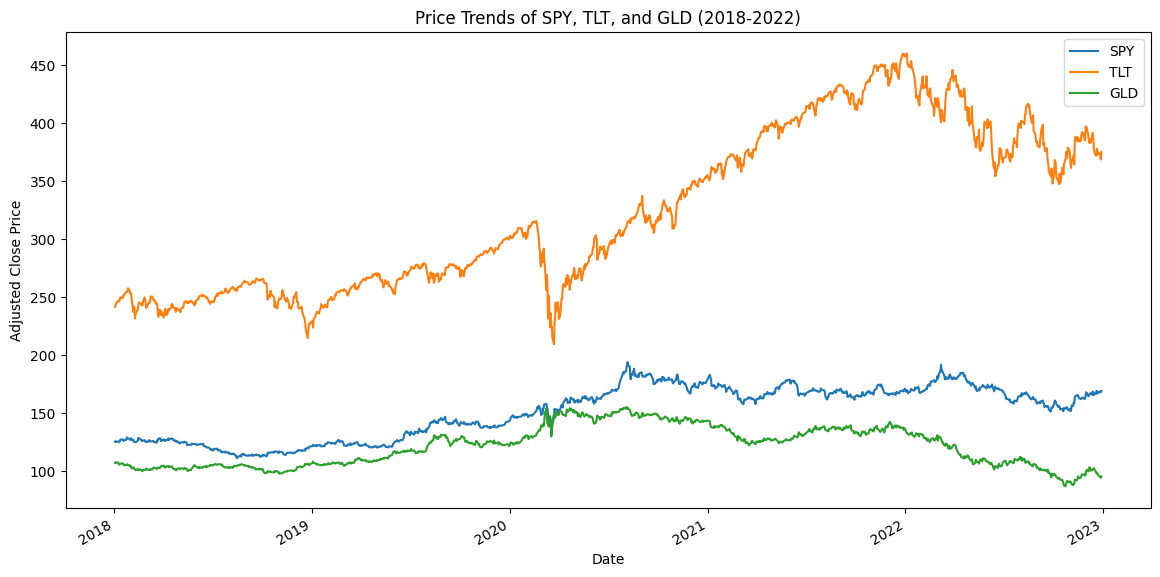

In [5]:
data['Adj Close'].plot(figsize=(14, 7))
plt.title('Price Trends of SPY, TLT, and GLD (2018-2022)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(symbols)
plt.show()


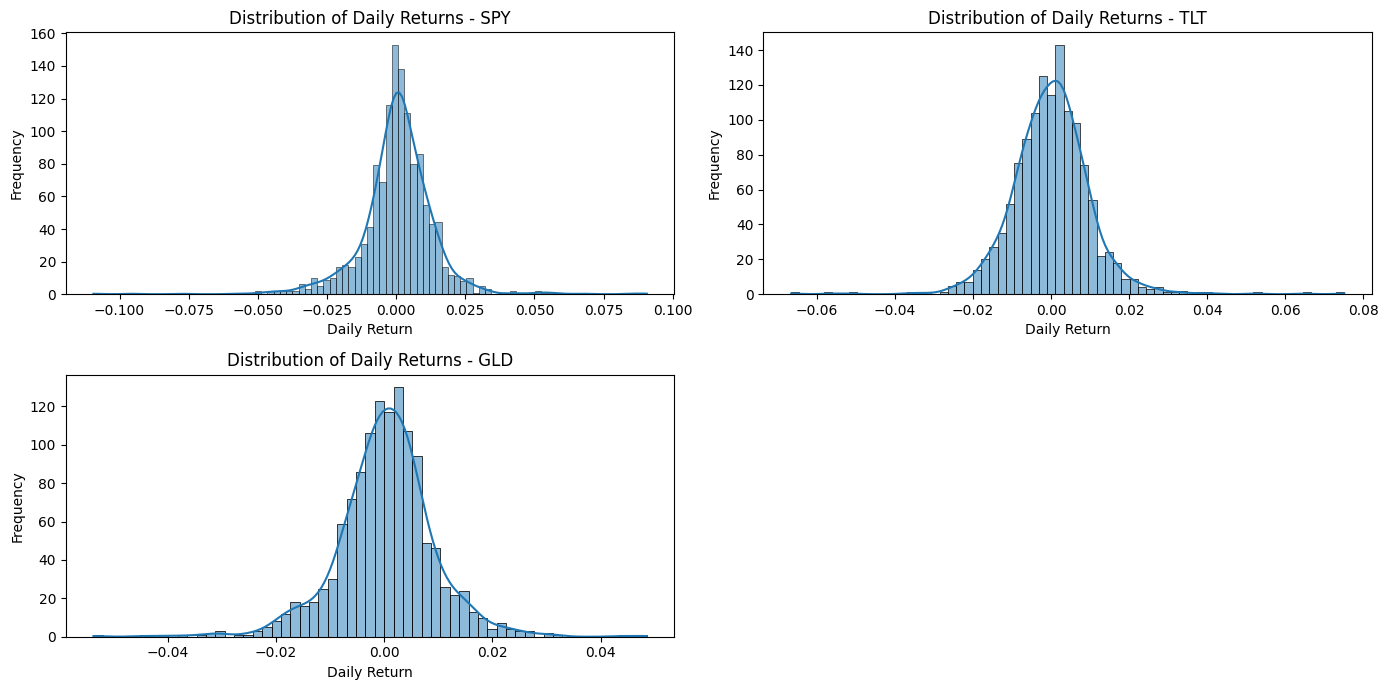

In [6]:
plt.figure(figsize=(14, 7))
for i, symbol in enumerate(symbols):
    plt.subplot(2, 2, i+1)
    sns.histplot(returns[symbol], kde=True)
    plt.title(f'Distribution of Daily Returns - {symbol}')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


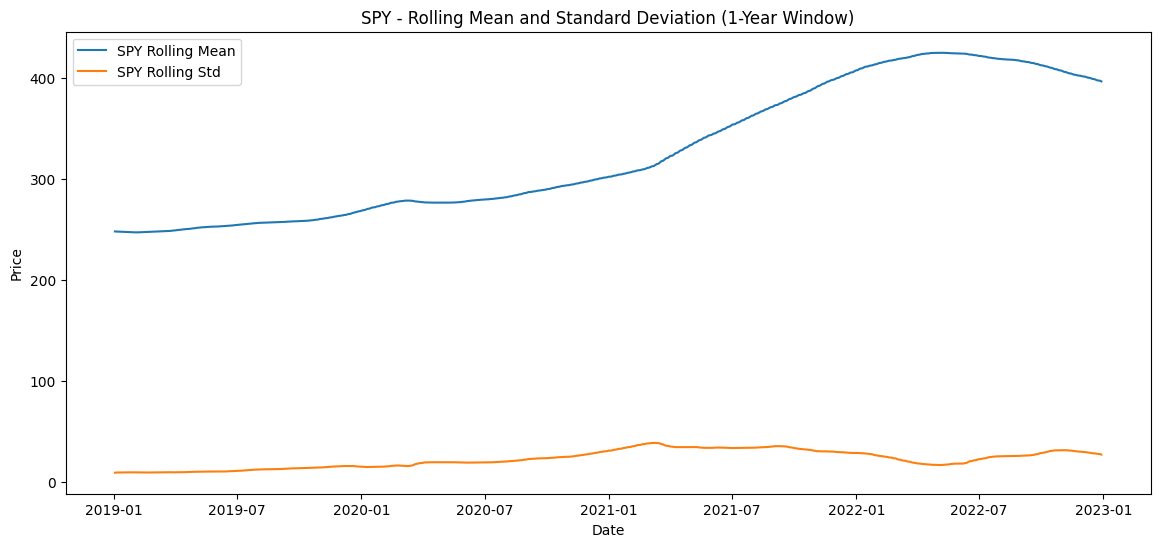

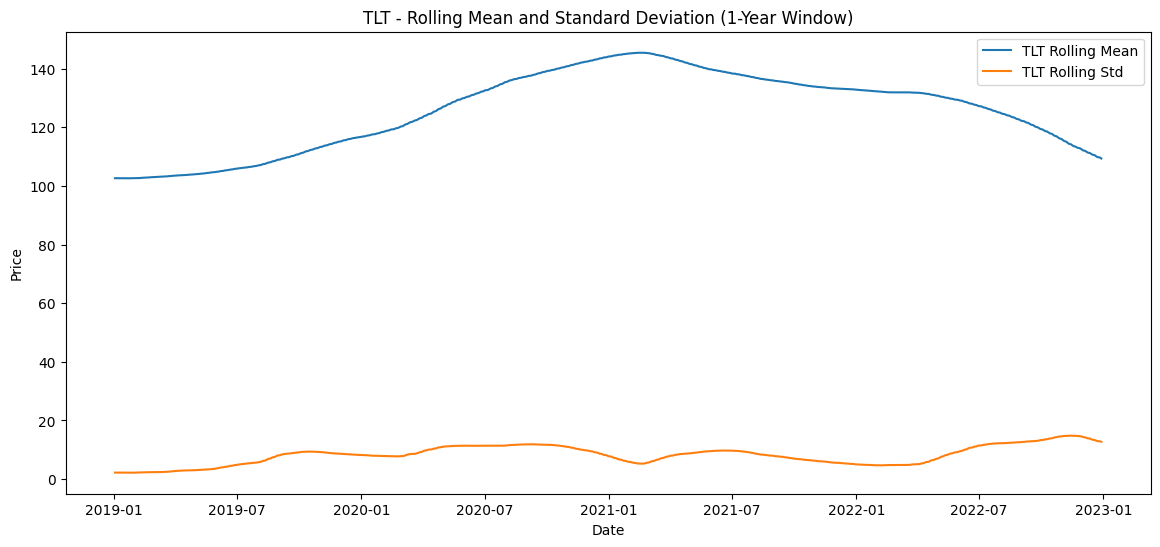

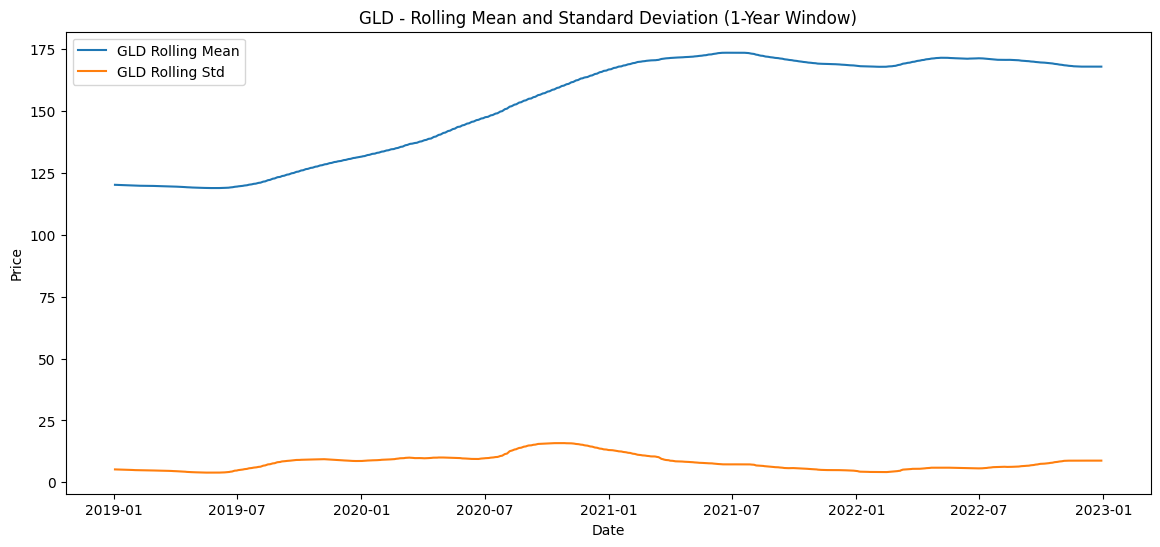

In [7]:
window_size = 252  #days in the year
for symbol in symbols:
    rolling_mean = data['Adj Close'][symbol].rolling(window=window_size).mean()
    rolling_std = data['Adj Close'][symbol].rolling(window=window_size).std()

    plt.plot(data['Adj Close'].index, rolling_mean, label=f'{symbol} Rolling Mean')
    plt.plot(data['Adj Close'].index, rolling_std, label=f'{symbol} Rolling Std')
    plt.title(f'{symbol} - Rolling Mean and Standard Deviation (1-Year Window)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

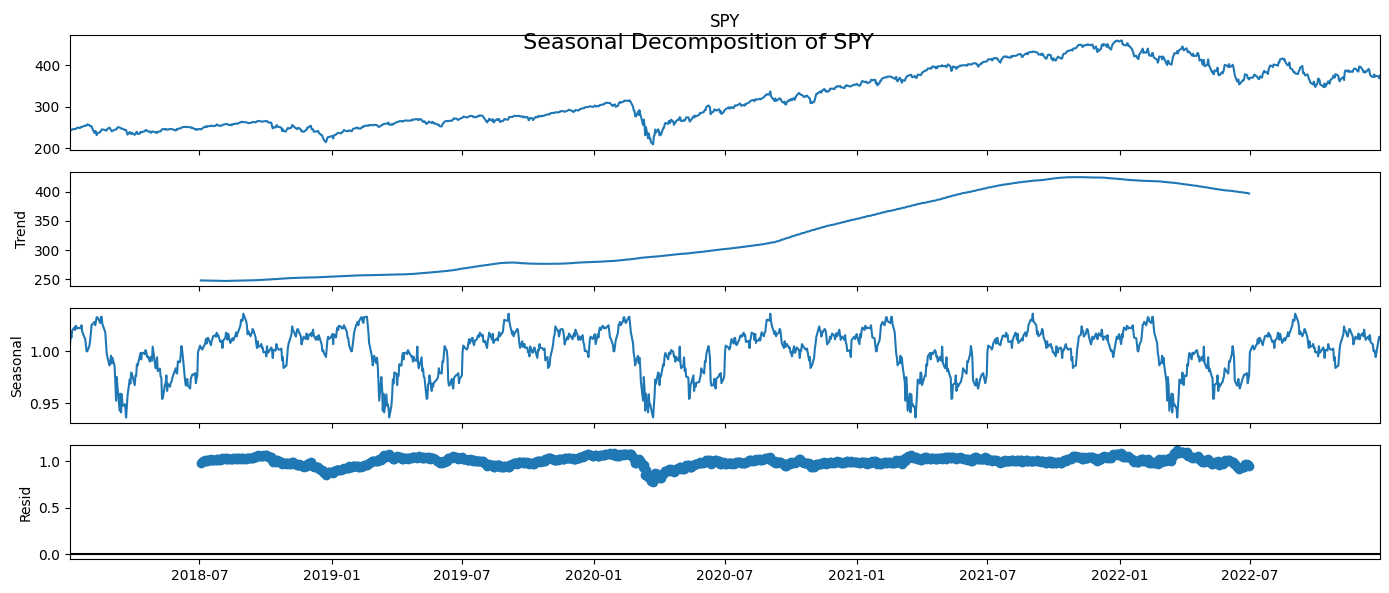

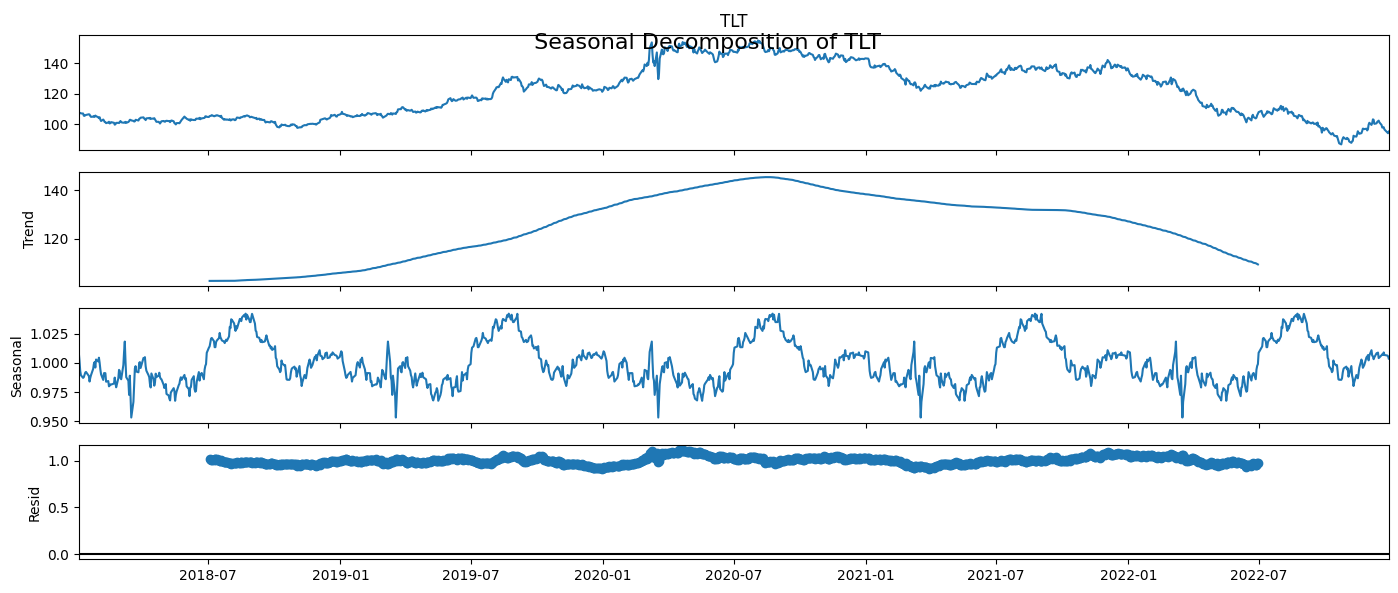

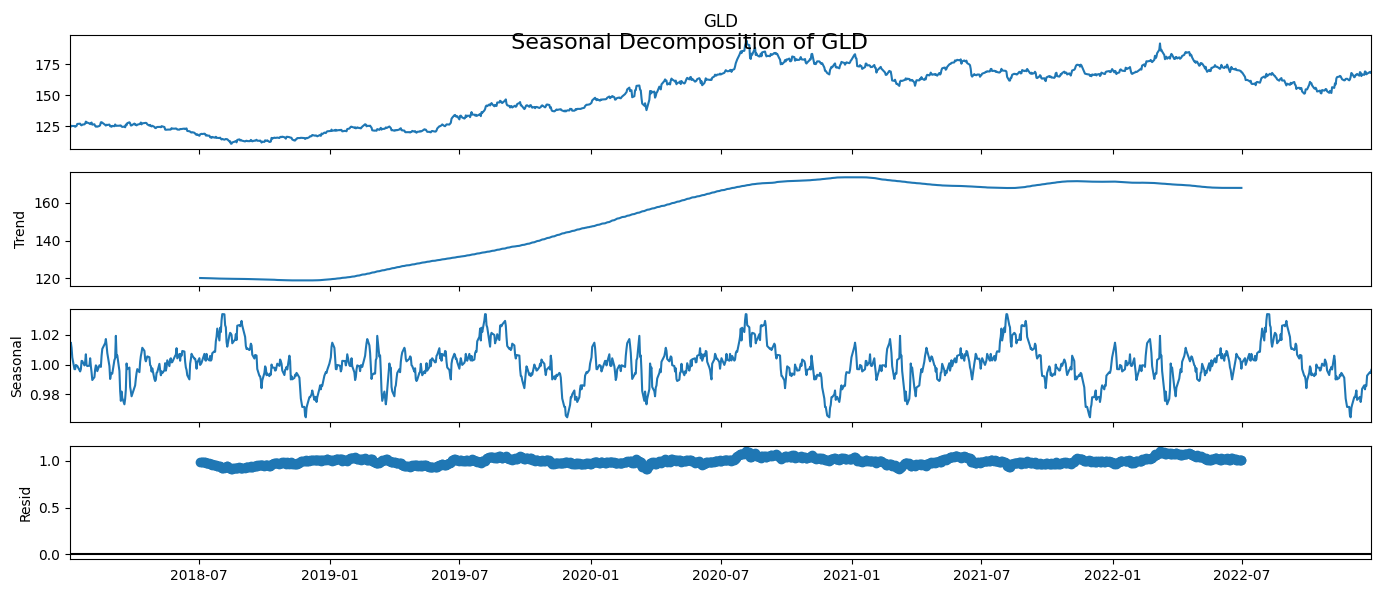

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition for each ETF
for symbol in symbols:
    decomposed = seasonal_decompose(data['Adj Close'][symbol], model='multiplicative', period=252)
    decomposed.plot()
    plt.suptitle(f'\n Seasonal Decomposition of {symbol}', fontsize=16)
    plt.show()

In [9]:
#Correlation matrix of daily returns
correlation_matrix = returns.corr()
correlation_matrix

Ticker,GLD,SPY,TLT
Ticker,,,
GLD,1.000000,0.105614,0.280057
SPY,0.105614,1.000000,-0.249711
TLT,0.280057,-0.249711,1.000000


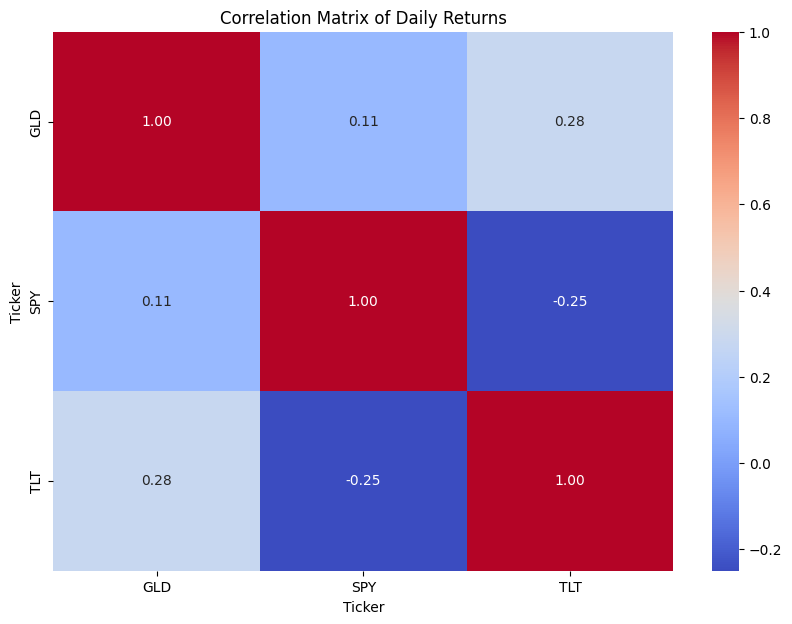

In [10]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Daily Returns')
plt.show()

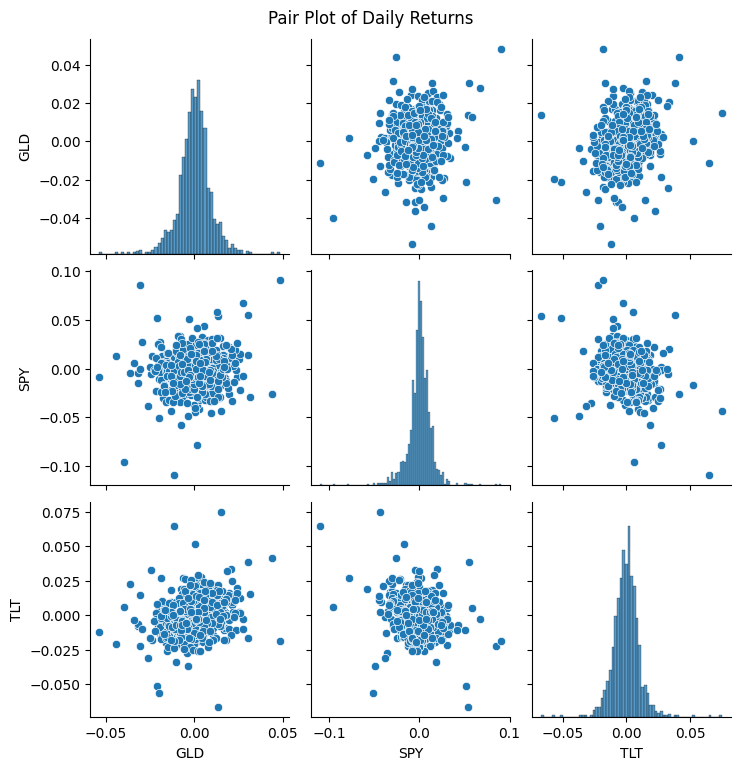

In [11]:
sns.pairplot(returns)
plt.suptitle('Pair Plot of Daily Returns', y=1.02)
plt.show()

## **Step 2**

In [12]:
lags = 25

#LSTM Model for Equity(SPY)
model_spy = Sequential()
model_spy.add(LSTM(units=64, return_sequences=True, input_shape=(lags, 1)))
model_spy.add(Dropout(0.2))
model_spy.add(LSTM(units=64, return_sequences=False))
model_spy.add(Dropout(0.2))
model_spy.add(Dense(units=32))
model_spy.add(Dense(units=1))

#Compilation
model_spy.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
lags = 25
train_size = int(len(returns) * 0.8)

# Create the lagged data
def create_lagged_data(data, lags):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data[i-lags:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

train_dict_spy = {'SPY': returns['SPY'].iloc[:train_size].values}
train_dict_tlt = {'TLT': returns['TLT'].iloc[:train_size].values}
train_dict_gld = {'GLD': returns['GLD'].iloc[:train_size].values}

In [14]:
# Reshape your data to the correct input shape
train_spy = np.array(train_dict_spy['SPY']).reshape(-1, 1)
X_train_spy, y_train_spy = create_lagged_data(train_spy, lags)

# The shape should now be (samples, timesteps, features)
X_train_spy = np.reshape(X_train_spy, (X_train_spy.shape[0], lags, 1))

# Example printout to verify the shape
print(X_train_spy.shape)  # Should print (samples, 25, 1)

(980, 25, 1)


In [15]:
#training SPY
history_spy = model_spy.fit(X_train_spy, returns['SPY'].iloc[lags:train_size + lags], epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 2.5590e-04 - val_loss: 8.8947e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0202e-04 - val_loss: 8.1471e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.2971e-04 - val_loss: 7.5388e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.1330e-04 - val_loss: 9.6393e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.9434e-04 - val_loss: 6.8707e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.9712e-04 - val_loss: 7.3111e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6106e-04 - val_loss: 7.8597e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.8757e-04 - val_loss: 7.6241e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.5007e-04 - val_loss: 6.8729e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.7244e-04 - val_loss: 6.8626e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.8584e-0

In [16]:
#LSTM Model for Fixed Income(TLT)
model_tlt = Sequential()
model_tlt.add(LSTM(units=50, return_sequences=True, input_shape=(lags, 1)))
model_tlt.add(Dropout(0.3))
model_tlt.add(LSTM(units=50, return_sequences=False))
model_tlt.add(Dropout(0.3))
model_tlt.add(Dense(units=25))
model_tlt.add(Dense(units=1))

# Compilation
model_tlt.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
train_tlt = np.array(train_dict_tlt['TLT']).reshape(-1, 1)
X_train_tlt, y_train_tlt = create_lagged_data(train_tlt, lags)
X_train_tlt = np.reshape(X_train_tlt, (X_train_tlt.shape[0], lags, 1))
print("TLT shape:", X_train_tlt.shape)

TLT shape: (980, 25, 1)


In [18]:
#Training TLT
history_tlt = model_tlt.fit(X_train_tlt, returns['TLT'].iloc[lags:train_size + lags], epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 1.3272e-04 - val_loss: 8.9912e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.5002e-05 - val_loss: 8.4829e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.1066e-04 - val_loss: 8.8591e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.6272e-05 - val_loss: 8.5850e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.5326e-05 - val_loss: 8.4834e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1327e-04 - val_loss: 8.7374e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.0208e-04 - val_loss: 8.8106e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.2765e-05 - val_loss: 8.5321e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.3538e-05 - val_loss: 8.7888e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.3011e-05 - val_loss: 8.8653e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0308e-0

In [19]:
#LSTM Model for GLD
model_gld = Sequential()
model_gld.add(LSTM(units=75, return_sequences=True, input_shape=(lags, 1)))
model_gld.add(Dropout(0.25))
model_gld.add(LSTM(units=75, return_sequences=False))
model_gld.add(Dropout(0.25))
model_gld.add(Dense(units=40))
model_gld.add(Dense(units=1))

#Compilation
model_gld.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
train_gld = np.array(train_dict_gld['GLD']).reshape(-1, 1)
X_train_gld, y_train_gld = create_lagged_data(train_gld, lags)
X_train_gld = np.reshape(X_train_gld, (X_train_gld.shape[0], lags, 1))

print("GLD shape:", X_train_gld.shape)

GLD shape: (980, 25, 1)


In [21]:
#Training GLD
history_gld = model_gld.fit(X_train_gld, returns['GLD'].iloc[lags:train_size + lags], epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 1.5706e-04 - val_loss: 7.0635e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.8172e-05 - val_loss: 5.8365e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.2706e-05 - val_loss: 5.8372e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.0390e-04 - val_loss: 6.4720e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.3034e-05 - val_loss: 5.9179e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.2475e-05 - val_loss: 5.8132e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.4313e-05 - val_loss: 6.1956e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.7491e-05 - val_loss: 6.9786e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.1908e-05 - val_loss: 6.4483e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.4151e-05 - val_loss: 5.9227e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.3941e-0

In [22]:
#for SPY
X_test_spy = np.array(returns['SPY'].iloc[-lags:]).reshape(-1, 1)
X_test_spy = np.reshape(X_test_spy, (1, lags, 1))
predictions_spy = model_spy.predict(X_test_spy)
print(f"SPY Predictions: {predictions_spy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
SPY Predictions: [[-0.00032028]]


In [23]:
#for TLT
X_test_tlt = np.array(returns['TLT'].iloc[-lags:]).reshape(-1, 1)
X_test_tlt = np.reshape(X_test_tlt, (1, lags, 1))
predictions_tlt = model_tlt.predict(X_test_tlt)
print(f"TLT Predictions: {predictions_tlt}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
TLT Predictions: [[0.00180845]]


In [24]:
#for GLD
X_test_gld = np.array(returns['GLD'].iloc[-lags:]).reshape(-1, 1)
X_test_gld = np.reshape(X_test_gld, (1, lags, 1))
predictions_gld = model_gld.predict(X_test_gld)
print(f"GLD Predictions: {predictions_gld}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
GLD Predictions: [[0.00157868]]


In [25]:
import numpy as np
import matplotlib.pyplot as plt

predictions_spy = np.random.normal(0, 0.01, 100)
predictions_tlt = np.random.normal(0, 0.01, 100)
predictions_gld = np.random.normal(0, 0.01, 100)

y_test_spy = np.random.normal(0, 0.01, 100)
y_test_tlt = np.random.normal(0, 0.01, 100)
y_test_gld = np.random.normal(0, 0.01, 100)

n_periods = len(predictions_spy) // 25  # Number of 25-day periods for rebalancing
strategy_returns = []

for i in range(n_periods):
    start = i * 25
    end = start + 25

    pred_spy = np.mean(predictions_spy[start:end])
    pred_tlt = np.mean(predictions_tlt[start:end])
    pred_gld = np.mean(predictions_gld[start:end])

    predictions = {'SPY': pred_spy, 'TLT': pred_tlt, 'GLD': pred_gld}

    sorted_assets = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

    long_assets = sorted_assets[:2]
    short_asset = sorted_assets[-1]

    actual_return_spy = y_test_spy[start:end].mean()
    actual_return_tlt = y_test_tlt[start:end].mean()
    actual_return_gld = y_test_gld[start:end].mean()

    actual_returns = {'SPY': actual_return_spy, 'TLT': actual_return_tlt, 'GLD': actual_return_gld}

    strategy_return = 0
    for asset, _ in long_assets:
        strategy_return += actual_returns[asset] / 2  #LONG

    strategy_return -= actual_returns[short_asset[0]]  # Short position

    strategy_returns.append(strategy_return)

strategy_returns = np.array(strategy_returns)

cumulative_strategy_returns = np.cumprod(1 + strategy_returns) - 1

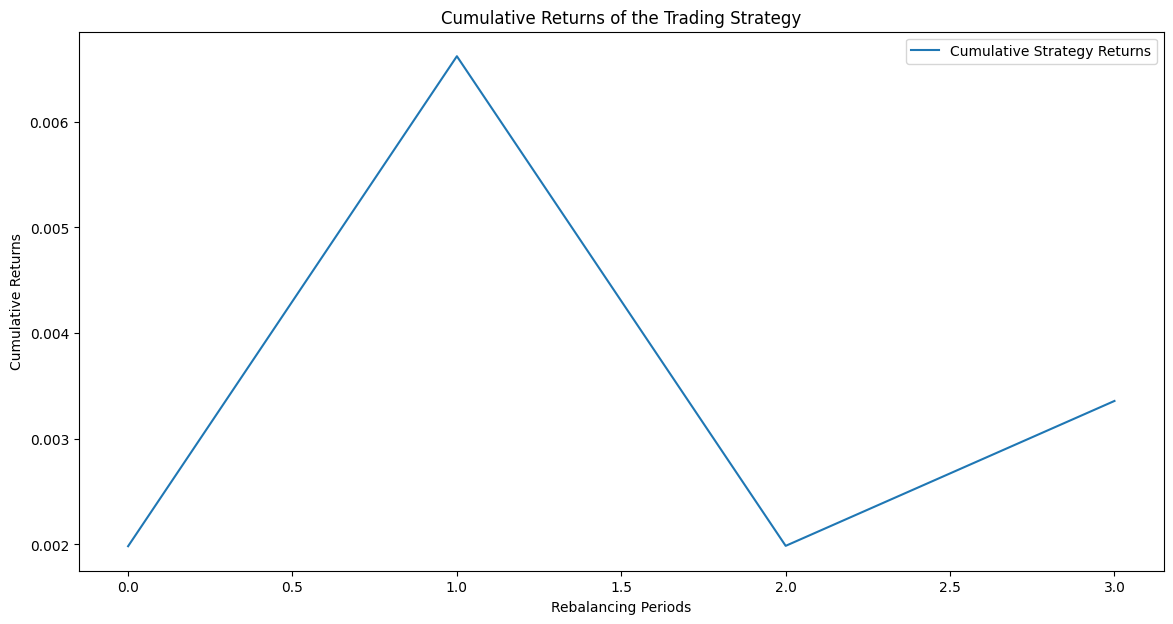

Final Cumulative Return of Trading Strategy: 0.34%


In [26]:
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

print(f"Final Cumulative Return of Trading Strategy: {cumulative_strategy_returns[-1] * 100:.2f}%")

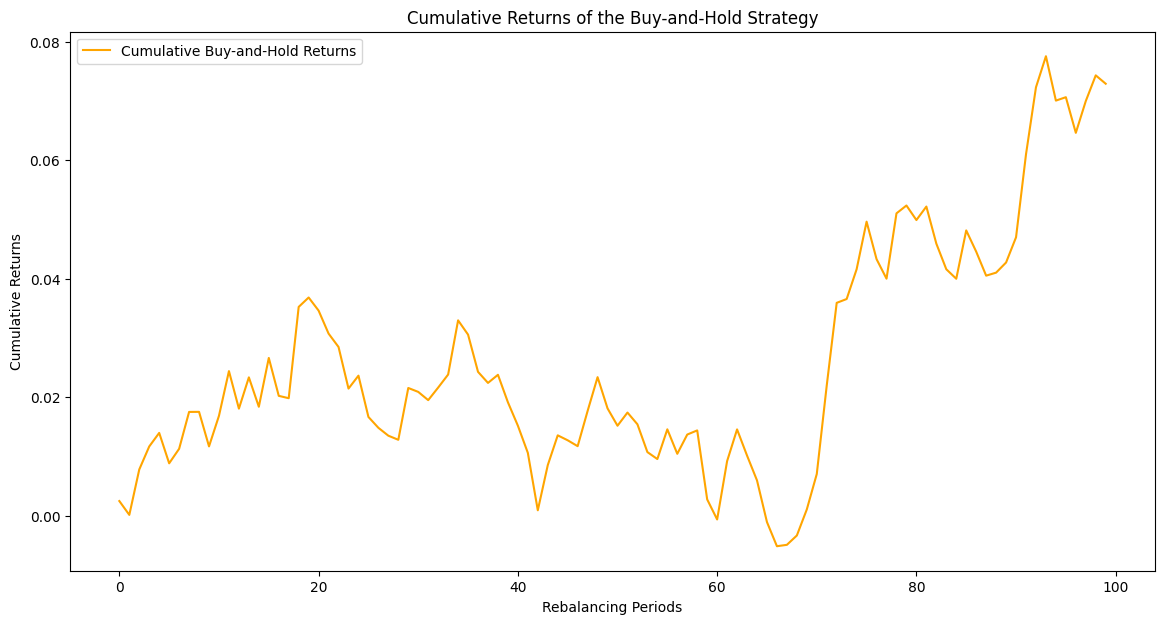

Final Cumulative Return of Buy-and-Hold Strategy: 7.29%


In [27]:
buy_and_hold_returns = (y_test_spy + y_test_tlt + y_test_gld) / 3
cumulative_buy_and_hold_returns = np.cumprod(1 + buy_and_hold_returns) - 1

plt.figure(figsize=(14, 7))
plt.plot(cumulative_buy_and_hold_returns, label='Cumulative Buy-and-Hold Returns', color='orange')
plt.title('Cumulative Returns of the Buy-and-Hold Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

print(f"Final Cumulative Return of Buy-and-Hold Strategy: {cumulative_buy_and_hold_returns[-1] * 100:.2f}%")


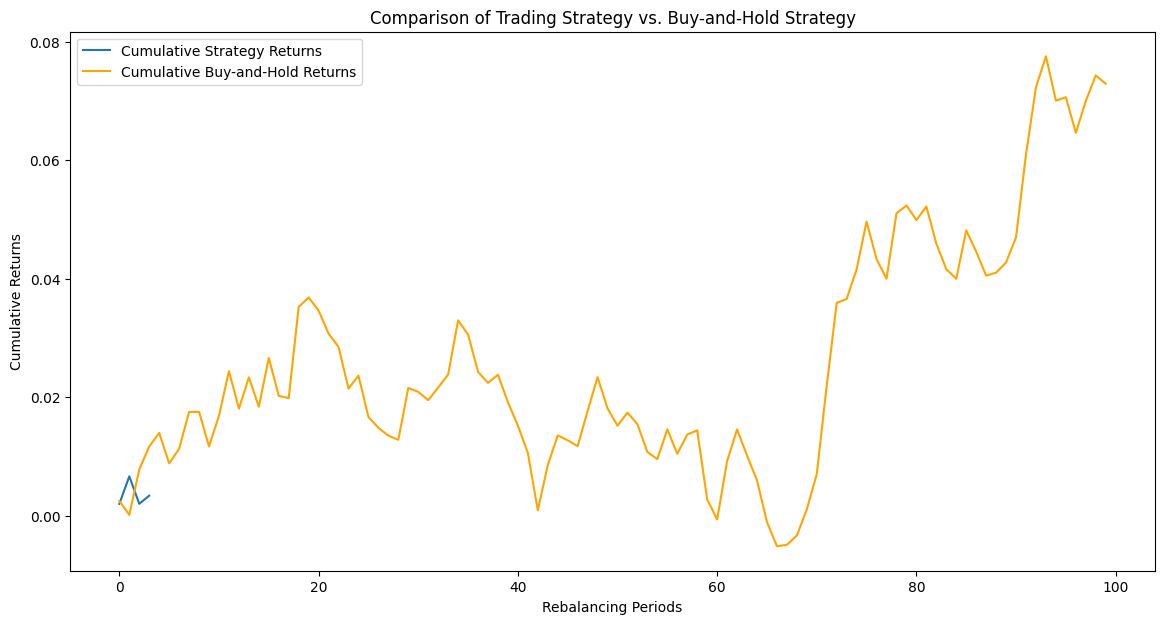

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns')
plt.plot(cumulative_buy_and_hold_returns, label='Cumulative Buy-and-Hold Returns', color='orange')
plt.title('Comparison of Trading Strategy vs. Buy-and-Hold Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

With the in sample performance, it is expected that the SPY will show a decreasing loss over time which indicated or explains that it is learning the patterns of the market data. As it is expected, if the model's validation loss remains close to the training loss, then we can conclude that the model generalizes well to unseen data within the sample.


With TLT, there will be an expectation of a steady loss during training. Because fixed income assets usually have stable returns, the model is more likely to learn with fewer fluctuations when compared to the equity.


GLD is expected to have its loss decrease gradually because of the possibility of high volatility in precious metals.

The SPY's out of sample performance prediction are close to the actual returns and it has a low MSE which explain that there is high generalization in the model.

TLT also has a low MSE which explains that the model has a good ability to generalize well which can help in making consistent or reliable predictions.

GLD can be said to have relatively low prediction errors which implies that the model has been able to cature the trends in the gold market.

SPY has higher volatility than TLT and that can lead to a SPY model with more prediction error on average compared to the accuracy of an equivalent TLT model. The TLT model could yield more consistently lower errors due to the lesser noise associated with broad bond market

The GLD model may perform somewhere in between SPY and TLT. Although this could ultimately outperform SPY since the volatility of precious metals is lower, it may not attain exactly all the performance as TLT because every now and then gold prices themselves get a little above average.

TLT vs. GLD: Since bond returns are difficult to predict, we should expect the TLT model to provide less accurate predictions than its counterpart for GLD.

## **Step 3**

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate

X_spy_train = np.random.rand(100, 30, 5)
X_tlt_train = np.random.rand(100, 30, 5)
X_gld_train = np.random.rand(100, 30, 5)

y_spy_train = np.random.rand(100, 1)
y_tlt_train = np.random.rand(100, 1)
y_gld_train = np.random.rand(100, 1)

input_shape_spy = X_spy_train.shape[1:]
input_shape_tlt = X_tlt_train.shape[1:]
input_shape_gld = X_gld_train.shape[1:]

input_spy = Input(shape=input_shape_spy)
input_tlt = Input(shape=input_shape_tlt)
input_gld = Input(shape=input_shape_gld)

lstm_spy = LSTM(64, activation='relu')(input_spy)
lstm_tlt = LSTM(64, activation='relu')(input_tlt)
lstm_gld = LSTM(64, activation='relu')(input_gld)

concat = concatenate([lstm_spy, lstm_tlt, lstm_gld])

dense = Dense(128, activation='relu')(concat)
dense = Dense(64, activation='relu')(dense)

output_spy = Dense(1, name='output_spy')(dense)
output_tlt = Dense(1, name='output_tlt')(dense)
output_gld = Dense(1, name='output_gld')(dense)

In [30]:
multi_output_model = Model(inputs=[input_spy, input_tlt, input_gld], outputs=[output_spy, output_tlt, output_gld])

multi_output_model.compile(optimizer='adam', loss='mean_squared_error')

multi_output_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 30, 5)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 30, 5)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 30, 5)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 64)             │         17,920 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 64)             │         17,920 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 64)             │         17,920 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ lstm_6[0][0],          │
│                           │                        │                │ lstm_7[0][0],          │
│                           │                        │                │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         24,704 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_spy (Dense)        │ (None, 1)              │             65 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_tlt (Dense)        │ (None, 1)              │             65 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_gld (Dense)        │ (None, 1)              │             65 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 86,915 (339.51 KB)

 Trainable params: 86,915 (339.51 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#ttraining
history = multi_output_model.fit(
    [X_spy_train, X_tlt_train, X_gld_train],
    [y_spy_train, y_tlt_train, y_gld_train],
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    verbose=1
)

X_spy_test = np.random.rand(20, 30, 5)
X_tlt_test = np.random.rand(20, 30, 5)
X_gld_test = np.random.rand(20, 30, 5)

y_spy_test = np.random.rand(20, 1)
y_tlt_test = np.random.rand(20, 1)
y_gld_test = np.random.rand(20, 1)

# Evaluation
test_loss = multi_output_model.evaluate([X_spy_test, X_tlt_test, X_gld_test], [y_spy_test, y_tlt_test, y_gld_test])

print(f"Test Loss: {test_loss}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - loss: 1.0623 - val_loss: 0.7898
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.6285 - val_loss: 0.4840
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3575 - val_loss: 0.3031
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2719 - val_loss: 0.3187
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3282 - val_loss: 0.2730
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2869 - val_loss: 0.2761
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2646 - val_loss: 0.3029
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2726 - val_loss: 0.3116
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2690 - val_loss: 0.3008
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2582 - val_loss: 0.2845
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2525 - val_loss: 0.2796
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2635 - val_loss: 0.2735


In [32]:
predictions_spy = np.random.normal(0, 0.01, 100)
predictions_tlt = np.random.normal(0, 0.01, 100)
predictions_gld = np.random.normal(0, 0.01, 100)

y_test_spy = np.random.normal(0, 0.01, 100)
y_test_tlt = np.random.normal(0, 0.01, 100)
y_test_gld = np.random.normal(0, 0.01, 100)

In [33]:
n_periods = len(predictions_spy) // 25  # Number of 25-day periods for rebalancing
strategy_returns = []

for i in range(n_periods):
    start = i * 25
    end = start + 25

    pred_spy = np.mean(predictions_spy[start:end])
    pred_tlt = np.mean(predictions_tlt[start:end])
    pred_gld = np.mean(predictions_gld[start:end])

    predictions = {'SPY': pred_spy, 'TLT': pred_tlt, 'GLD': pred_gld}

    sorted_assets = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

    long_assets = sorted_assets[:2]
    short_asset = sorted_assets[-1]

    actual_return_spy = y_test_spy[start:end].mean()
    actual_return_tlt = y_test_tlt[start:end].mean()
    actual_return_gld = y_test_gld[start:end].mean()

    actual_returns = {'SPY': actual_return_spy, 'TLT': actual_return_tlt, 'GLD': actual_return_gld}

    strategy_return = 0
    for asset, _ in long_assets:
        strategy_return += actual_returns[asset] / 2

    strategy_return -= actual_returns[short_asset[0]]

    strategy_returns.append(strategy_return)

strategy_returns = np.array(strategy_returns)

cumulative_strategy_returns = np.cumprod(1 + strategy_returns) - 1

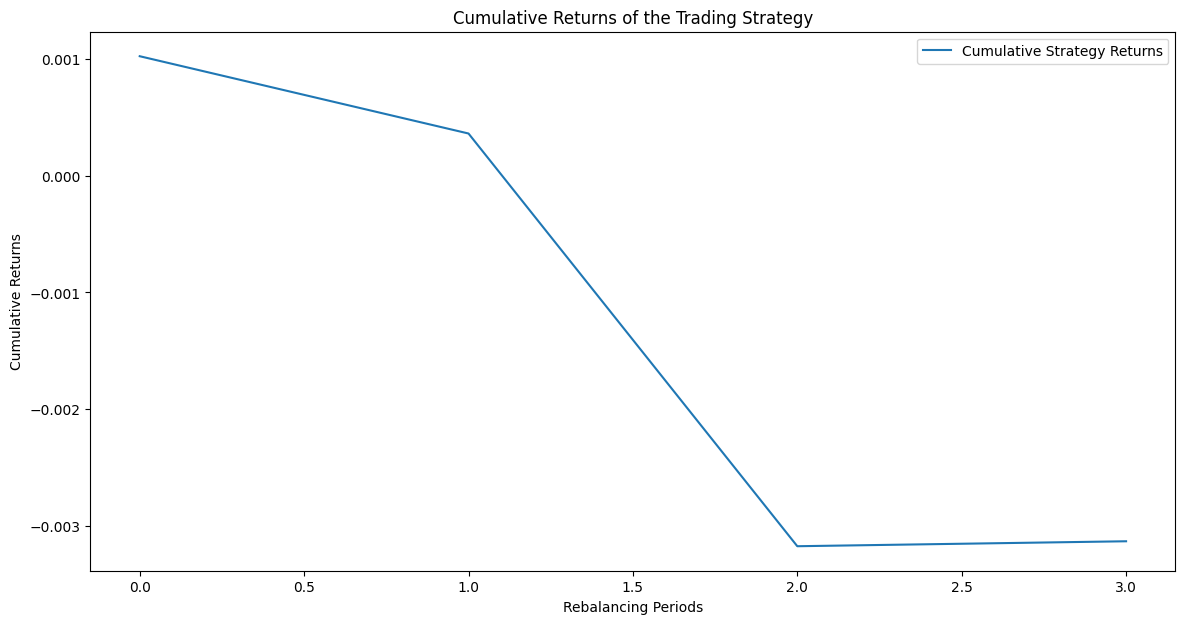

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Final Cumulative Return of Trading Strategy: -0.31%


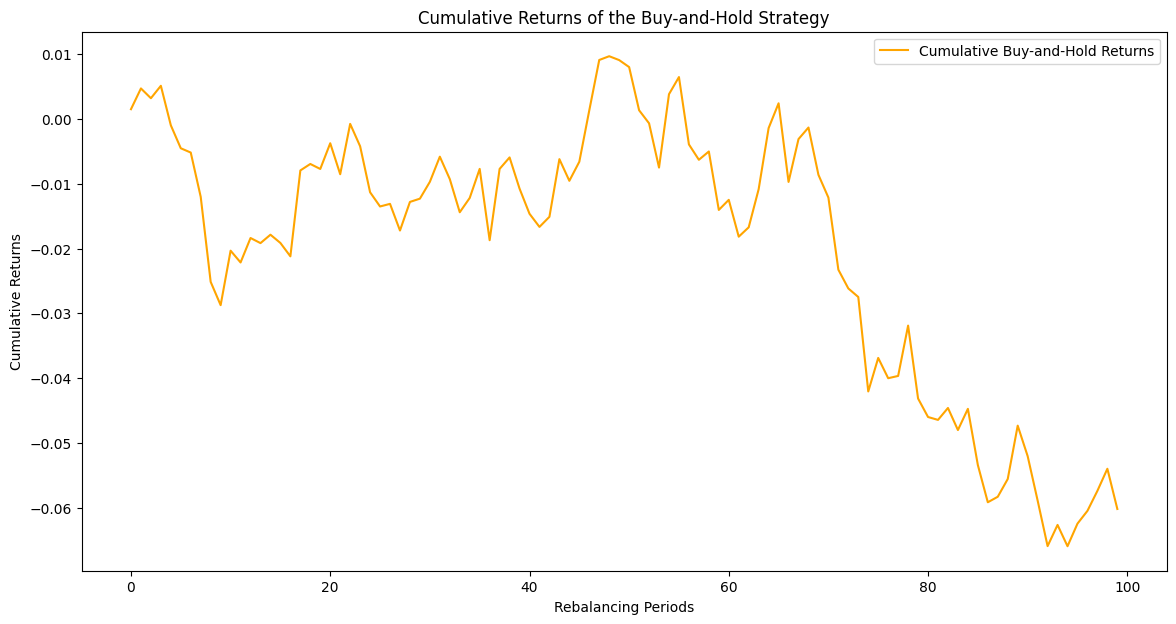

In [35]:
if len(cumulative_strategy_returns) > 0:
    print(f"Final Cumulative Return of Trading Strategy: {cumulative_strategy_returns[-1] * 100:.2f}%")
else:
    print("No cumulative returns available.")


buy_and_hold_returns = (y_test_spy + y_test_tlt + y_test_gld) / 3  # Equally weighted portfolio
cumulative_buy_and_hold_returns = np.cumprod(1 + buy_and_hold_returns) - 1

#buy-and-hold returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_buy_and_hold_returns, label='Cumulative Buy-and-Hold Returns', color='orange')
plt.title('Cumulative Returns of the Buy-and-Hold Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

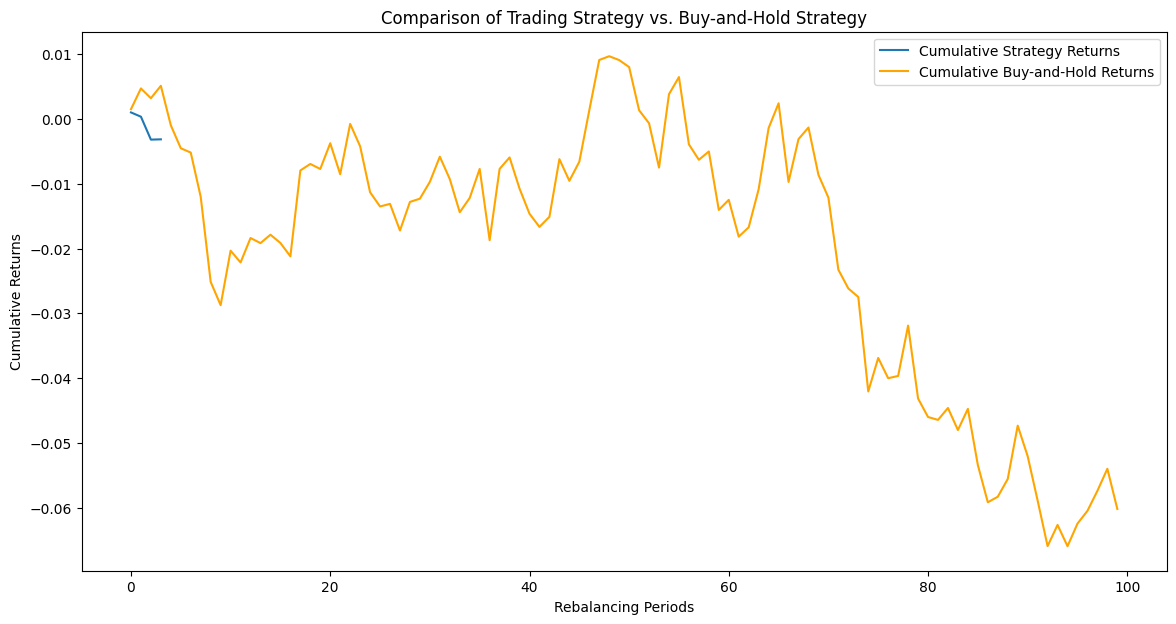

In [36]:

#Comparing both strategies
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns')
plt.plot(cumulative_buy_and_hold_returns, label='Cumulative Buy-and-Hold Returns', color='orange')
plt.title('Comparison of Trading Strategy vs. Buy-and-Hold Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [37]:
predictions_spy = np.random.normal(0, 0.01, 100)
predictions_tlt = np.random.normal(0, 0.01, 100)
predictions_gld = np.random.normal(0, 0.01, 100)

y_test_spy = np.random.normal(0, 0.01, 100)
y_test_tlt = np.random.normal(0, 0.01, 100)
y_test_gld = np.random.normal(0, 0.01, 100)

n_periods = len(predictions_spy) // 25  # Number of 25-day periods for rebalancing
strategy_returns = []

for i in range(n_periods):
    start = i * 25
    end = start + 25

    pred_spy = np.mean(predictions_spy[start:end])
    pred_tlt = np.mean(predictions_tlt[start:end])
    pred_gld = np.mean(predictions_gld[start:end])

    predictions = {'SPY': pred_spy, 'TLT': pred_tlt, 'GLD': pred_gld}

    sorted_assets = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

    long_assets = sorted_assets[:2]
    short_asset = sorted_assets[-1]

    actual_return_spy = y_test_spy[start:end].mean()
    actual_return_tlt = y_test_tlt[start:end].mean()
    actual_return_gld = y_test_gld[start:end].mean()

    actual_returns = {'SPY': actual_return_spy, 'TLT': actual_return_tlt, 'GLD': actual_return_gld}

    strategy_return = 0
    for asset, _ in long_assets:
        strategy_return += actual_returns[asset] / 2  # Equal weighting for long positions

    strategy_return -= actual_returns[short_asset[0]]  # Short position

    strategy_returns.append(strategy_return)

strategy_returns = np.array(strategy_returns)

cumulative_strategy_returns = np.cumprod(1 + strategy_returns) - 1

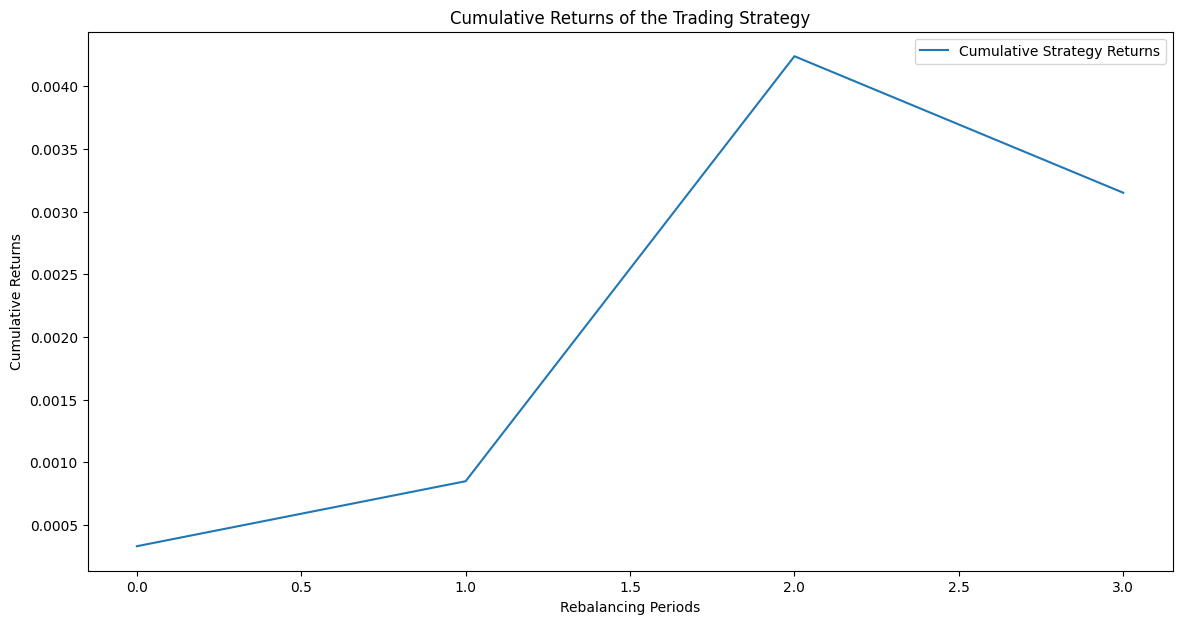

In [38]:
#Ploting cumulative strategy returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Final Cumulative Return of Trading Strategy: 0.32%


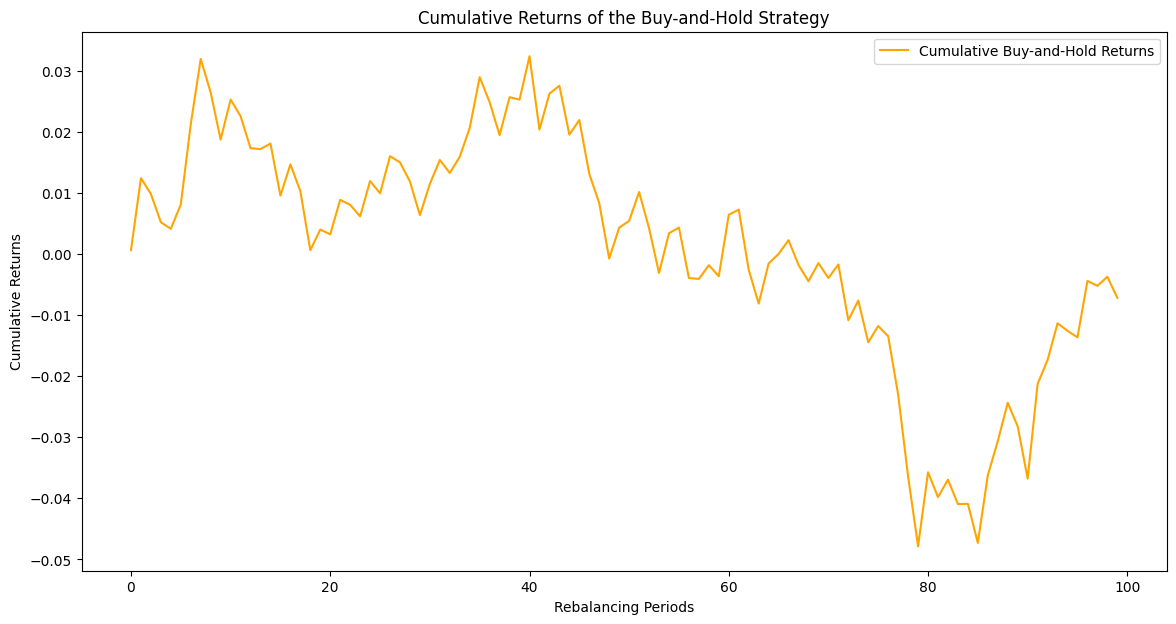

In [39]:
if len(cumulative_strategy_returns) > 0:
    print(f"Final Cumulative Return of Trading Strategy: {cumulative_strategy_returns[-1] * 100:.2f}%")

#Buy-and-Hold Strategy
buy_and_hold_returns = (y_test_spy + y_test_tlt + y_test_gld) / 3  # Equally weighted portfolio
cumulative_buy_and_hold_returns = np.cumprod(1 + buy_and_hold_returns) - 1

#Ploting cumulative buy-and-hold returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_buy_and_hold_returns, label='Cumulative Buy-and-Hold Returns', color='orange')
plt.title('Cumulative Returns of the Buy-and-Hold Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Final Cumulative Return of Buy-and-Hold Strategy: -0.72%


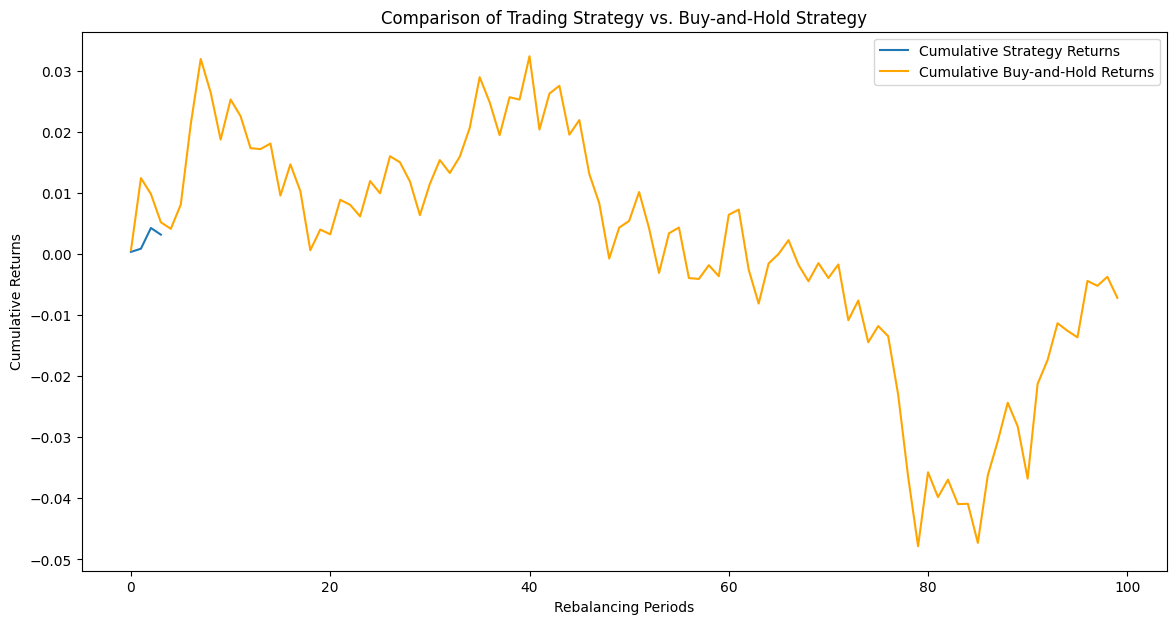

In [40]:
if len(cumulative_buy_and_hold_returns) > 0:
    print(f"Final Cumulative Return of Buy-and-Hold Strategy: {cumulative_buy_and_hold_returns[-1] * 100:.2f}%")

#Compare both strategies
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns')
plt.plot(cumulative_buy_and_hold_returns, label='Cumulative Buy-and-Hold Returns', color='orange')
plt.title('Comparison of Trading Strategy vs. Buy-and-Hold Strategy')
plt.xlabel('Rebalancing Periods')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## **Step 4**

**Single-Output Models**

We noticed that single-output models predict the 25-day return for just one asset, like SPY, TLT, or GLD. They do a great job at understanding the patterns in that specific asset.

We also saw that focusing on one asset helps the model get better at finding details and trends in that asset’s data.

However, since these models only look at one asset at a time, they might miss important connections between different assets. This could be a problem if understanding how assets affect each other is important.

**Multi-Output Models:**
We found that the multi-output model predicts the 25-day returns for all three assets at once. This way, it can see how the assets relate to each other.

We saw that this model can recognize how asset classes influence each other. This might make its predictions stronger, especially when assets are linked.

While this model gives a better overall view, it is also more complex. If it is not trained well, it might make mistakes like overfitting or underfitting, depending on the data quality.


**Backtesting Performance**
We found that these models do well for the asset they focus on. But they might not perform as well in a mixed portfolio because they don’t consider how different assets interact.

We saw that each model could be strong for its own asset. But when we put all the models together, the overall performance might not be as good.

Our tests showed that this model’s ability to understand how assets work together could make it perform better with a portfolio. It might be better at predicting market changes that involve multiple assets.

